# How to create a TB simulation


This notebook demonstrates how to create and run simulations for tuberculosis (TB) using the `tbsim` and `starsim` libraries. The simulations will model the spread and impact of TB over time on a population.


## Packages

The code in this section imports the `starsim` package, which provides the capabilities to create and run simulations.
Note that while `tbsim` enables some functionality, the full capabilities are provided by `starsim`.


In [53]:

# Import necessary libraries
import tbsim as mtb
import starsim as ss
import matplotlib.pyplot as plt


## High level steps

As suggested by the starsim 'Getting Started' tutorial (https://docs.idmod.org/projects/starsim/en/latest/tutorials/tut_intro.html) we will proceed with the most common tasks for modeling infectious diseases, in our case, TB:

1. Defining parameters (Building the simulation):
2. Running a simulation 
3. Plotting results



## Building the simulation

In this case, in order to make our code reusable  we will encapsulate all our preparation steps in the following function, `make_tb`. This function puts together all what is needed for a simulation to run and returns a <b style="color: gold; "> simulation object</b> with a tuberculosis disease, methods, etc., and with user specified parameters. NOTE: Default values are generally specified as part of the __init__ method for each class, i.e. people, network, tb, etc.).



### People:
- Creates a population of 1,000 agents using the People class from the starsim (aliased as ss) library.

### TB Disease
- Defines the disease parameters for TB:
    - beta: Transmission rate.
    - init_prev: Initial prevalence of TB (25%).
- Initializes the TB model with these parameters using the tbsim library (aliased as mtb).

### Network
- Defines the network parameters:
    - n_contacts: Number of contacts per agent, following a Poisson distribution with a mean (lambda) of 5.
    - dur: Duration of contact (0 means end after one timestep).
- Initializes a random network with these parameters.

### Demographics

The demographics section sets up two demographic processes for the simulation: pregnancy and death rates. These, define and incorporate key demographic events into the simulation model:

- **Pregnancy**: Adds new agents to the population at a rate of 15 per 1,000 people. (TODO: Verify if this is done every time every step or if this is a one time event at set_prognoses)
- **Deaths**: Removes agents from the population at a rate of 10 per 1,000 people. (same question as above)

This setup ensures the simulation realistically accounts for population changes over time due to births and deaths.

### Simulation Parameters and Initialization

This part of the code defines the parameters for the simulation and initializes it using these parameters:

1. **Defining Simulation Parameters**:
    - **`dt=ss.days(7)/365`**: This defines the time step (`dt`) for the simulation. Here, `7/365` represents a weekly time step,  the simulation progresses in weekly increments.
    - **`start = 1990`**: This sets the starting year of the simulation to 1990.
    - **`end = 2000`**: This sets the ending year of the simulation to 2000.

2. **Initializing the Simulation**:
    - **`ss.Sim`**: This is a class from the `starsim` package used to create a simulation object.
    - **Parameters**:
        - **`people=pop`**: Specifies the population object created earlier.
        - **`networks=net`**: Specifies the network object that describes how agents are connected.
        - **`diseases=tb`**: Specifies the TB disease model initialized earlier.
        - **`pars=sim_pars`**: Passes the simulation parameters defined above.
        - **`demographics=dems`**: Specifies the list of demographic events (pregnancy and death rates).

3. **Setting Verbosity**:
    - This line adjusts how frequently the simulation prints its status updates.
    - **`sim.pars.dt / 5`**: By dividing the time step (`dt`) by 5, the simulation is set to print updates every 5 years. This ensures that the status updates are less frequent but still provide periodic insights into the simulation's progress.

4. **Returning the Simulation Object**:
    - This returns the initialized simulation object so that it can be run or further interacted with outside of the `make_tb` function.



In [54]:
# Define the function to create a tuberculosis simulation
def make_tb():
    # --------------- People ----------
    initial_population_size = 1000
    pop = ss.People(n_agents=initial_population_size)
    
    # --------------- TB disease --------
    tb_pars = dict(  # Disease parameters
        beta = 0.001, 
        init_prev = 0.25,
        )
    tb = mtb.TB(tb_pars) # Initialize

    # --------------- Network ---------
    net_pars = dict(    # Network parameters
        n_contacts=ss.poisson(lam=5),
        dur = 0, # End after one timestep
        )
    net = ss.RandomNet(net_pars)  # Initialize a random network

    # --------------- Demographics --------
    dems = [
        ss.Pregnancy(pars=dict(fertility_rate=15)), # Per 1,000 people
        ss.Deaths(pars=dict(death_rate=10)), # Per 1,000 people
    ]

    # --------------- simulation -------
    sim_pars = dict(    # define simulation parameters
        dt=ss.days(7)/365,
        start = 1990,
        stop = 2020,
        )
    sim = ss.Sim(people=pop, networks=net, diseases=tb, pars=sim_pars, demographics=dems)   # initialize the simulation
    sim.pars.verbose = sim.pars.dt / 5      # Print status every 5 years instead of every 10 steps
    return sim



### Run the Simulation

We will now create and run the first simulation using the `make_tb` function with the parameters set above. 

Please note, at some point it may be convenient to parameterize the `make_tb` function and make it even more re-usable (for intance for scenarios creation).


In [55]:

# Create and run the first simulation
sim = make_tb()  # Create the simulation - running make_tb returns a simulation of a type ss.Sim (from starsim library) therefore we can use all the methods of the ss.Sim class
sim.run()        # Run the simulation 


Initializing sim with 1000 agents
  Running 1990.0 ( 0/1565) (0.00 s)  ———————————————————— 0%
  Running 1995.0 (260/1565) (0.43 s)  •••————————————————— 17%
  Running 2000.0 (520/1565) (0.85 s)  ••••••—————————————— 33%
  Running 2005.0 (780/1565) (1.26 s)  •••••••••——————————— 50%
  Running 2009.9 (1040/1565) (1.68 s)  •••••••••••••——————— 67%
  Running 2014.9 (1300/1565) (2.08 s)  ••••••••••••••••———— 83%
  Running 2019.9 (1560/1565) (2.48 s)  •••••••••••••••••••— 100%


Sim(n=1000; 1990—2020; networks=randomnet; demographics=pregnancy, deaths; diseases=tb)

## Analyzing The Results


Let's first review the data that was generated (and is available in the results array). This collected data is specified in the [init_results](https://github.com/starsimhub/tbsim/blob/b6e569f1f3e41dc1e2f95e9eb78fc15a5816b8dc/tbsim/tb.py#L237), and then updated in the [update_results](https://github.com/starsimhub/tbsim/blob/b6e569f1f3e41dc1e2f95e9eb78fc15a5816b8dc/tbsim/tb.py#L245) TB functions. For more detailed information, please refer to the official documentation at [StarSim Results API](https://docs.idmod.org/projects/starsim/en/latest/api/_autosummary/starsim.results.Result.html).

In [56]:
tbr = sim.diseases['tb'].results

print("This is a dictionary of the results that you can plot: \n",tbr.keys())


This is a dictionary of the results that you can plot: 
 ['timevec', 'n_susceptible', 'n_infected', 'n_on_treatment', 'n_ever_infected', 'prevalence', 'new_infections', 'cum_infections', 'n_latent_slow', 'n_latent_fast', 'n_active', 'n_active_presymp', 'n_active_presymp_15+', 'n_active_smpos', 'n_active_smpos_15+', 'n_active_smneg', 'n_active_smneg_15+', 'n_active_exptb', 'n_active_exptb_15+', 'new_active', 'new_active_15+', 'cum_active', 'cum_active_15+', 'new_deaths', 'new_deaths_15+', 'cum_deaths', 'cum_deaths_15+', 'n_infectious', 'n_infectious_15+', 'prevalence_active', 'incidence_kpy', 'deaths_ppy', 'n_reinfected', 'new_notifications_15+', 'n_detectable_15+']


now, below we show the plotting of a single channel (result):

Text(0.5, 1.0, 'The most basic plotting sample \n TB Prevalence \n (raw data)')

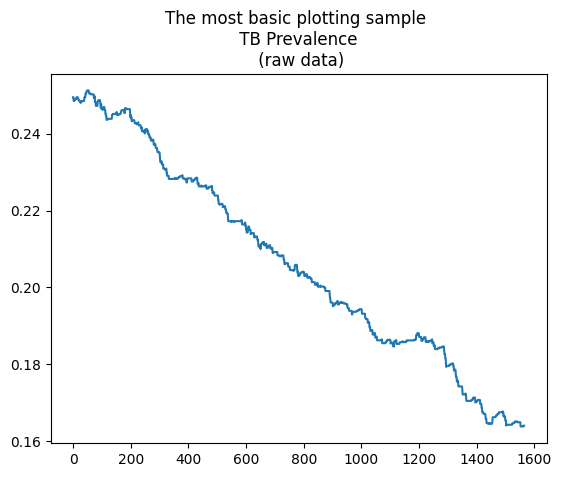

In [57]:

plt.plot(range(0,len(tbr['prevalence'])),tbr['prevalence'])
plt.title("The most basic plotting sample \n TB Prevalence \n (raw data)")



## <h1 style="color: orange; ">Plotting</h1>
<p>Once you get familiar with the available data in the results array, you can proceed to plot your results using your favorite method.</p>

### <h3 style="color: lightblue; ">1: Using the starsim library</h3>
<p>Plot the results of the simulation - inherited from the starsim library which is available under the diseases attribute of the simulation: <code> sim.plot() </code> </p>



Figure(1200x900)


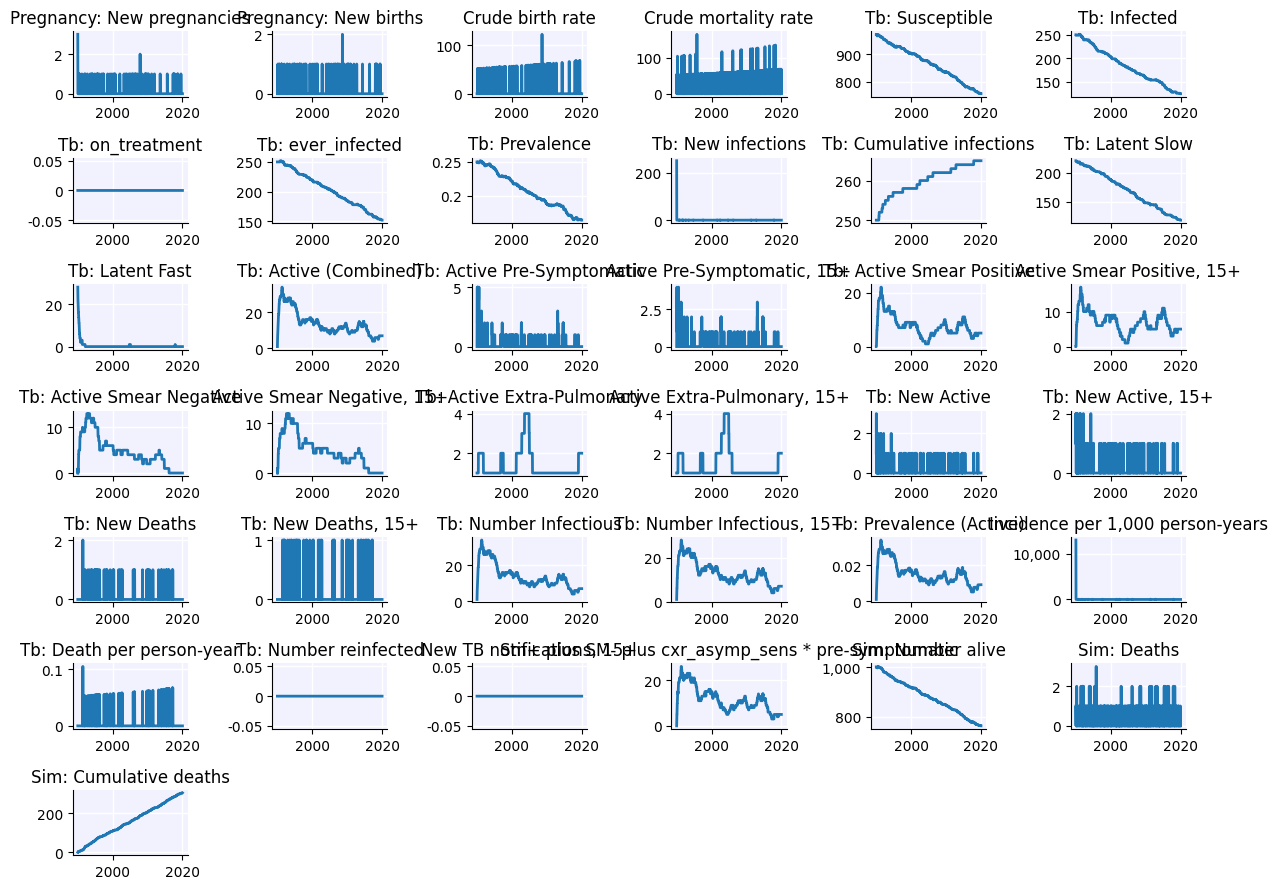

In [58]:
sim.plot()

### Using TBSim plots:
mtb.plot_combined()
where: 
    {'single simulation': sim.results.flatten(), 'tb only results': sim.diseases['tb'].results.flatten()}
each key will be a scenario plotted with a different color

for more information mouse over the 'plot_combined' function.


Saved figure to /Users/mine/git/tbdocs/docs/tutorials/results/scenarios_20250725_135254.png


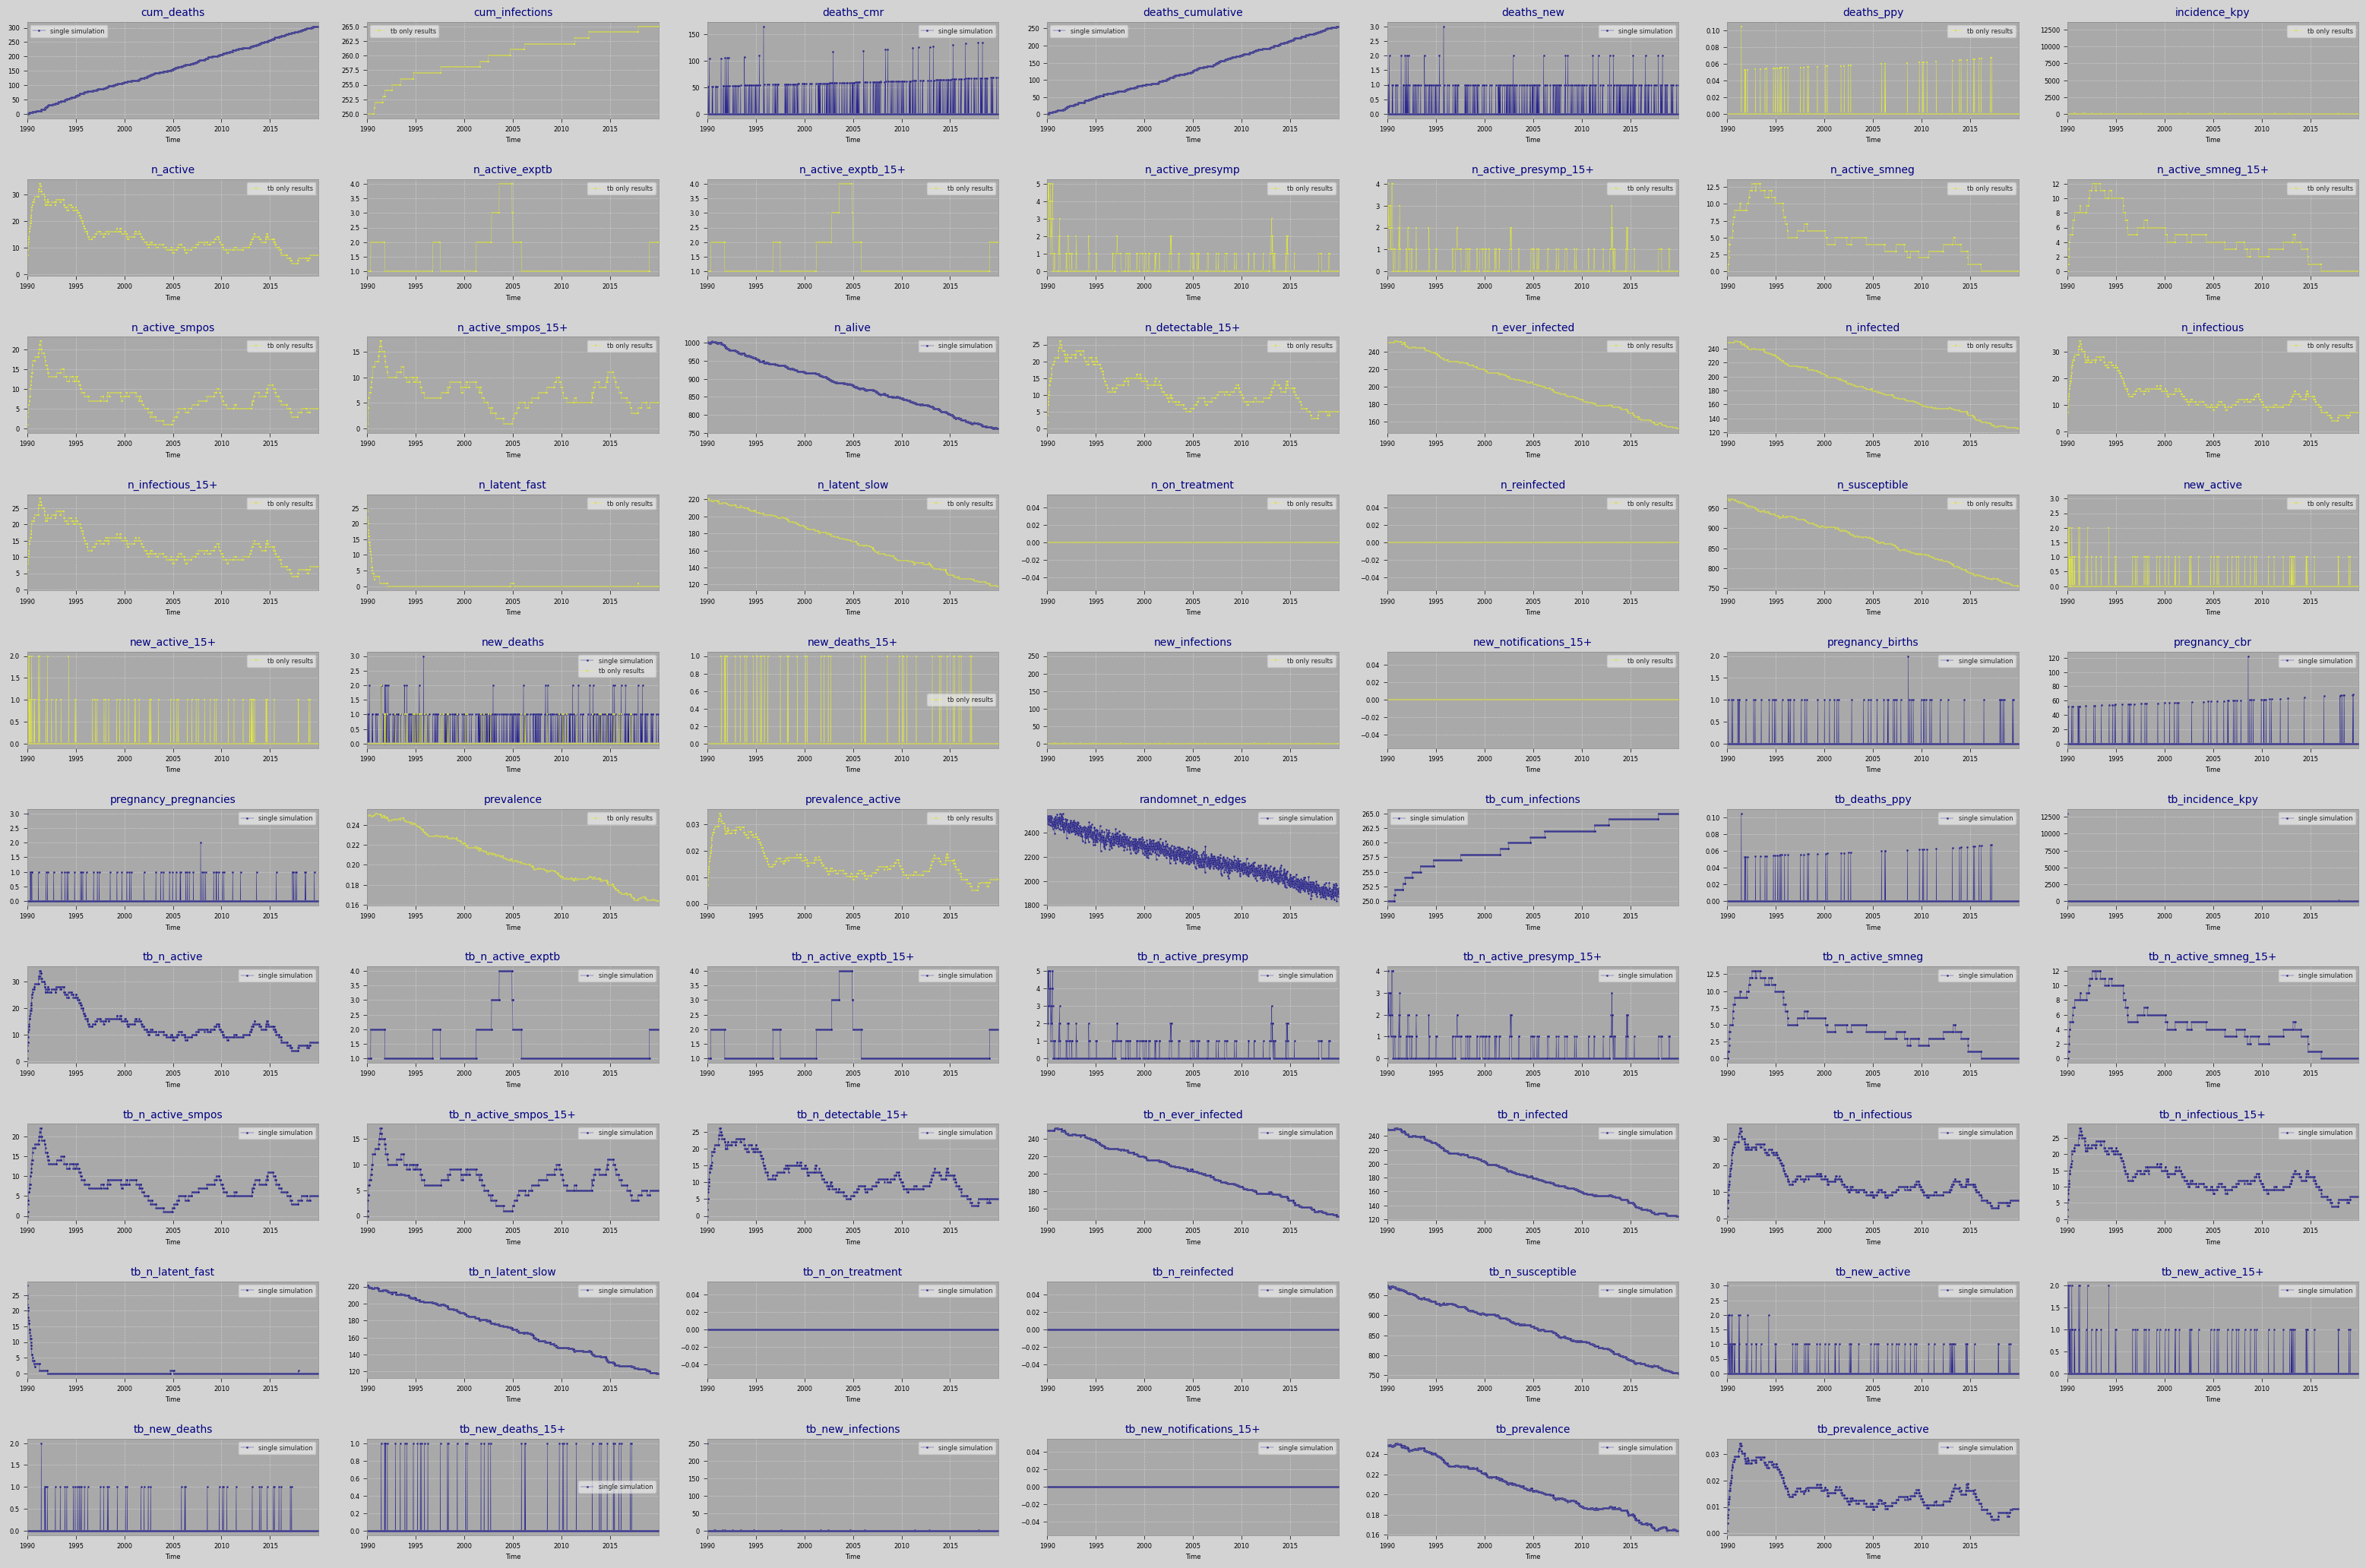

In [59]:
mtb.plot_combined({'single simulation': sim.results.flatten(), 'tb only results': sim.diseases['tb'].results.flatten()})

### Using your own function

Take a look at the sample below, it will show you how to access the results dataframe (dict) and how with a simple function you can plot your simulation's results.

Text(0.5, 1.0, 'A basic sample of plotting sim results')

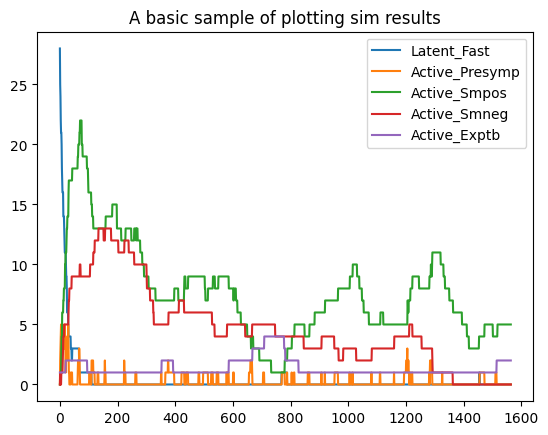

In [60]:

# Method 3:  ------------------------------------------------------
fig = plt.figure()
simulation_results = sim.results['tb']
for rkey in [ 'latent_fast', 'active_presymp', 'active_smpos', 'active_smneg', 'active_exptb']:
    plt.plot(simulation_results['n_'+rkey], label=rkey.title())
plt.legend()
plt.title("A basic sample of plotting sim results")
